In [62]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        
        # Policy MLP: 28 -> 256 -> 256 -> 256 output
        self.policy_net = nn.Sequential(
            nn.Linear(28, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh()
        )
        
        # Value MLP: 28 -> 256 -> 256 -> 256 output
        self.value_net = nn.Sequential(
            nn.Linear(28, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh()
        )
        
        # Final layers
        self.action_net = nn.Linear(256, 7)  # 7 actions
        self.value_out = nn.Linear(256, 1)  # State-value output

    def forward(self, x):
        """
        Returns the action logits and the state-value given inputs x.
        Expected input shape is (batch_size, 28).
        If your input is multi-dimensional, flatten it first (dim=1).
        """
        # Flatten in case input is multi-dimensional (e.g. [B, ...])
        x = torch.flatten(x, start_dim=1)
        
        # Get policy features
        policy_features = self.policy_net(x)
        # Get value features
        # value_features = self.value_net(x)
        
        # Compute final outputs
        action_logits = self.action_net(policy_features)
        # state_value = self.value_out(value_features)
        
        return action_logits
    
defence_model = ActorCritic()

In [64]:
defence_train_x = np.load('defencebot_imitation_traininput_posdif.npy')
defence_train_y = np.load('defencebot_imitation_trainlabel_posdif.npy')

print(defence_train_x.shape)
# defence_train_x = defence_train_x[:,-1,:,:]
# defence_train_x = defence_train_x.reshape(-1, 28)
print(defence_train_x.shape)
print(defence_train_y.shape)

# defence_train_x = defence_train_x / np.max(np.abs(defence_train_x))
# defence_train_y = defence_train_y / np.max(np.abs(defence_train_y))

defence_train_x = torch.tensor(defence_train_x, dtype=torch.float32)
defence_train_y = torch.tensor(defence_train_y, dtype=torch.float32)

defence_set = torch.utils.data.TensorDataset(defence_train_x, defence_train_y)

(3834, 28)
(3834, 28)
(3834, 7)


epoch: 0, defence_loss: 2.221651554107666
epoch: 1, defence_loss: 1.9063080549240112
epoch: 2, defence_loss: 2.036278009414673
epoch: 3, defence_loss: 1.9279959201812744
epoch: 4, defence_loss: 2.073742628097534
epoch: 5, defence_loss: 2.124544620513916
epoch: 6, defence_loss: 1.9314039945602417
epoch: 7, defence_loss: 1.7494721412658691
epoch: 8, defence_loss: 1.988425612449646
epoch: 9, defence_loss: 1.9948598146438599
epoch: 10, defence_loss: 1.8942214250564575
epoch: 11, defence_loss: 2.0112357139587402
epoch: 12, defence_loss: 2.0888850688934326
epoch: 13, defence_loss: 1.9411485195159912
epoch: 14, defence_loss: 1.8315355777740479
epoch: 15, defence_loss: 2.0751376152038574
epoch: 16, defence_loss: 1.7097710371017456
epoch: 17, defence_loss: 2.2154011726379395
epoch: 18, defence_loss: 1.6737582683563232
epoch: 19, defence_loss: 2.005995035171509
epoch: 20, defence_loss: 1.84273099899292
epoch: 21, defence_loss: 1.9041880369186401
epoch: 22, defence_loss: 1.9744988679885864
epoch:

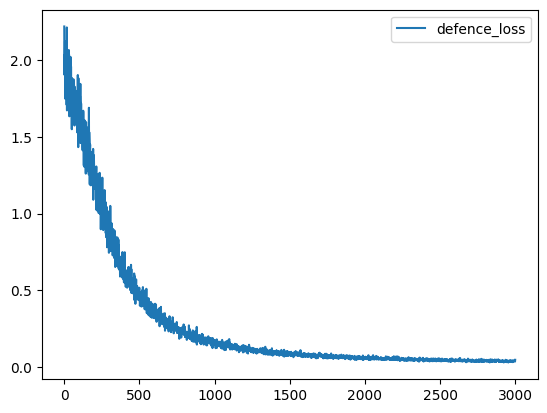

In [ ]:
epoch_num = 3000
batch_size = 256

defence_loader = torch.utils.data.DataLoader(defence_set, batch_size=batch_size, shuffle=True)

defence_optimizer = optim.Adam(defence_model.parameters(), lr=0.001, weight_decay=0.00002)

defence_loss_fn = nn.MSELoss()

defence_losses = []

for epoch in range(epoch_num):
    defence_loss = 0
    for x, y in defence_loader:
        defence_optimizer.zero_grad()
        y_pred = defence_model(x)
        defence_loss = defence_loss_fn(y_pred, y)
        defence_loss.backward()
        defence_optimizer.step()
        defence_loss += defence_loss.item()
    defence_losses.append(defence_loss.detach().numpy())
    print(f'epoch: {epoch}, defence_loss: {defence_loss}')
#save the model
torch.save(defence_model.state_dict(), 'defence_model_imitation_posdif.pth')
plt.plot(defence_losses, label='defence_loss')
plt.legend()
plt.show()

**Testing Begins Here**

In [2]:
import robotic as ry
import time
import numpy as np
import os
import time
import matplotlib.pyplot as plt

C = ry.Config()
C.addFile("rai-robotModels/scenarios/pandasFight.g")@misc{kingma2017adammethodstochasticoptimization,
      title={Adam: A Method for Stochastic Optimization}, 
      author={Diederik P. Kingma and Jimmy Ba},
      year={2017},
      eprint={1412.6980},
      archivePrefix={arXiv},
      primaryClass={cs.LG},
      url={https://arxiv.org/abs/1412.6980}, 
}


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class attack_defence_agents(nn.Module):
    def __init__(self, input_size = 7*2, seq_len = 10 ,hidden_size = 256, output_size = 7):
        super().__init__()

        self.a_lstm = nn.LSTM(input_size, hidden_size, batch_first = True, num_layers=2)
        self.a_fc = nn.Linear(hidden_size, hidden_size)
        self.a_fc2 = nn.Linear(hidden_size, output_size)        
        
        self.b_lstm = nn.LSTM(input_size, hidden_size, batch_first = True, num_layers=2)
        self.b_fc = nn.Linear(hidden_size, hidden_size)
        self.b_fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x, agent):
        if agent == 'a':
            x, (hn, cn) = self.a_lstm(x)
            x = hn[-1]
            x = F.relu(self.a_fc(x))
            x = self.a_fc2(x)
        elif agent == 'b':
            x, (hn,cn) = self.b_lstm(x)
            x = hn[-1]
            x = F.relu(self.b_fc(x))
            x = self.b_fc2(x)
        return x
model = attack_defence_agents()
model.load_state_dict(torch.load('attack_defence_model.pth'))

/tmp/ipykernel_8461/1626317715.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('attack_defence_model.pth'))


<All keys matched successfully>

In [4]:
#Define simulation functions
C = ry.Config()
C.addFile("rai-robotModels/scenarios/pandasFight.g")

C.setJointState(np.array([ 0.  , -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.  ,  0.  ,
       -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.]))

q0 = C.getJointState()
S = ry.Simulation(C, ry.SimulationEngine.physx, verbose=0)
def simulationCloseGrippers(S, tau=0.01):
    S.closeGripper('l_gripper', width=0.0001, speed=0.5)
    while (not S.getGripperIsGrasping('l_gripper')) and (S.getGripperWidth('l_gripper') > 0.001):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()
    
    S.closeGripper('r_gripper', width=0.0001, speed=0.5)
    while (not S.getGripperIsGrasping('r_gripper')) and (S.getGripperWidth('r_gripper') > 0.001):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()


def simulationOpenGrippers(S, tau=0.01):
    S.openGripper('l_gripper', width=0.05, speed=0.5)
    while S.getGripperWidth('l_gripper') < 0.05 - 0.01:
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()
    S.openGripper('r_gripper', width=0.05, speed=0.5)
    while S.getGripperWidth('r_gripper') < 0.05 - 0.01:
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()

def simulationGoTo(S, q, tau=0.01, checkCol=False):
    checkColTime = 0.1
    timer = 0
    while np.linalg.norm(S.get_q() - q) > 0.01:
        time.sleep(tau)
        S.step(q, tau, ry.ControlMode.position)
        timer += tau
        C.view()
        if timer > 4:
            print("Target cannot be reached within 4 seconds.")
            break
        if checkCol:
            if timer > checkColTime:
                if findCollision(C, 'sword_1'):
                    return
                else:
                    checkColTime += 0.1

def simulationGoHome(S, tau=0.01):
    checkColTime = 0.1
    timer = 0
    while np.linalg.norm(S.get_q() - q0) > 0.01:
        time.sleep(tau)
        S.step(q0, tau, ry.ControlMode.position)
        C.view()
        timer += tau
        # if timer > checkColTime:
        #     if findCollision(C, 'sword_1'):
        #         break
        #     else:
        #         checkColTime += 0.1
            
def simulationFollowPath(S, path, tau=0.01):
    checkColTime = 0.1
    timer = 0
    for i in range(len(path)):
        while np.linalg.norm(S.get_q() - path[i]) > 0.3:
            time.sleep(tau)
            print(i)
            print(np.linalg.norm(S.get_q() - path[i]))
            S.step(path[i], tau, ry.ControlMode.position)
            #C.view()
            timer += tau
            if timer > checkColTime:
                print('check_col')
                if findCollision(C, 'sword_1'):
                    return
                else:
                    checkColTime += 0.1

    simulationGoTo(S, path[-1], checkCol=True)

def simulationWait(S, t, tau=0.01):
    for k in range(int(t / tau)):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        #C.view()

def simulationTorqueCtrl(S, t, torque, tau=0.01):
    for k in range(int(t / tau)):
        time.sleep(tau)
        S.step(torque, tau, ry.ControlMode.acceleration)
        #C.view()

def simulationVelocityCtrl(S,t,vel,tau=0.01):
    for k in range(int(t/tau)):
        time.sleep(tau)
        S.step(vel,tau,ry.ControlMode.velocity)
        #C.view()

def followInterpolatedPath(S,path,tau=0.01):
    checkColTime = 0.1
    timer = 0
    for i in range(len(path)):
        time.sleep(tau)
        print(i)
        print(np.linalg.norm(S.get_q()- path[i]))
        S.step(path[i],tau,ry.ControlMode.position)
        #C.view()
        timer += tau
        if timer > checkColTime:
            if findCollision(C,'sword_1'):
                return
            else:
                checkColTime += 0.1
    simulationGoTo(S,path[-1],checkCol=True)

def findCollision(C,object1):
    collisions = [col for col in C.getCollisions(0) if object1 in col and not col[1].startswith('l_') and not col[0].startswith('l_')]
    if len(collisions) > 0:
        return True
    else:
        return False

def findCollisionshield(C):
    collisions = [col for col in C.getCollisions(0) if 'shi' in col and 'sword_1' in col]
    if len(collisions) > 0:
        return True
    else:
        return False
        
# Use this code. It is awesome. It will follow the path and stop if there is a collision.    
def followSplinePath(S,C,path,t,tau=0.01):
    """
        Guides a simulation object along a specified spline path.
        Parameters:
        S (Simulation): The simulation object that will follow the path.
        path (array): A list of waypoints defining the spline path.
        t (float): The total time duration for following the path.
        tau (float, optional): The time step for each simulation step. Default is 0.01.
        The function performs the following steps:
        1. Resets the spline reference of the simulation object.
        2. Sets the spline reference with the given path and a time vector.
        3. Iteratively steps through the simulation, updating the view and checking for collisions.
        4. If a collision with 'sword_1' is detected, the function exits early.
        5. The loop runs for a duration slightly longer than `t` to ensure completion.
        Note:
        - The `+20` in the loop range is a heuristic to prevent early termination when `t` is low.
        - The function checks for collisions every 0.1 seconds.

    """
    checkColTime = 0.1
    timer = 0
    S.resetSplineRef() # Reset previous spline reference
    S.setSplineRef(path,np.linspace(0.01,t,len(path))) # Set new spline reference
    joint_data = np.empty((int(t/tau)+20, 2,S.get_q().shape[0])) # Initialize array to store joint data
    for k in range(int(t/tau)+20): # This +20 is heuristic. It was stopping after a short time when t was low.
        time.sleep(tau)
        S.step([],tau,ry.ControlMode.spline)
        inst_pos = S.get_q().copy()
        inst_vel = S.get_qDot().copy()
        C.view(message=f"Time: {timer:.2f} s")
        timer += tau
        joint_data[k,0,:] = inst_pos
        joint_data[k,1,:] = inst_vel
        if timer > checkColTime: # Check for collisions every 0.1 seconds
            if findCollision(C,'sword_1'): # Check if sword is colliding with something (left robot is excluded (no self collision))
                return joint_data[:k,:,:] # Return the joint data until collision
            else:
                checkColTime += 0.1 # Increment the collision check time

    return joint_data[np.newaxis,:,:,:]
    #simulationGoTo(S,path[-1],checkCol=True) 


In [5]:
import time
def initializeSimulation():
    simulationGoTo(S,armed)
    simulationCloseGrippers(S)
    simulationGoHome(S)

In [9]:
C = ry.Config()
C.addFile("rai-robotModels/scenarios/pandasFight.g")

C.setJointState(np.array([ 0.  , -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.  ,  0.  ,
       -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.]))

q0 = C.getJointState()
random_joint_states = q0+np.random.uniform(-1,1,14)*0.25*np.pi

S = ry.Simulation(C, ry.SimulationEngine.physx, verbose=0)
initializeSimulation()
simulationGoTo(S,random_joint_states)
C.view()
time.sleep(1)
a_data = np.empty((10,14))
d_data = np.empty((10,14))
model.eval()
for i in range(200):

    if i > 10:
        attack = model(torch.tensor(a_data[np.newaxis,:,:], dtype=torch.float32), 'a').detach().numpy()
        defence = model(torch.tensor(d_data[np.newaxis,:,:], dtype=torch.float32), 'b').detach().numpy()
        target_pos = np.concatenate([attack[0]* np.pi,defence[0] *np.pi])
    else:
        target_pos = C.getJointState()

    S.step(target_pos, 0.01, ry.ControlMode.position)
    pos = S.get_q()
    vel = S.get_qDot()
    a_data[i%10,0:7] = pos[0:7]
    a_data[i%10,7:] = vel[0:7]

    d_data[i%10,0:7] = pos[7:]
    d_data[i%10,7:] = vel[7:]
    C.view()
    

del C
del S

-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]
